In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

hp = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

hp.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


## Data Exploration

First I want to look at the target variable's distribution and see if there are any outliers in it. 

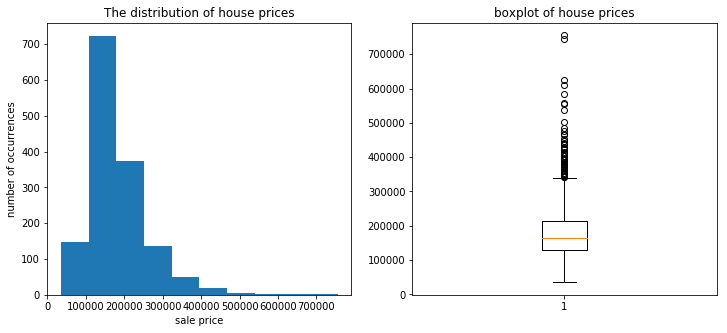

In [3]:
#look at target variable distribution
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.hist(hp.saleprice)
plt.title("The distribution of house prices")
plt.xlabel("sale price")
plt.ylabel("number of occurrences")

plt.subplot(1, 2, 2)
plt.boxplot(hp.saleprice)
plt.title("boxplot of house prices")

plt.show()

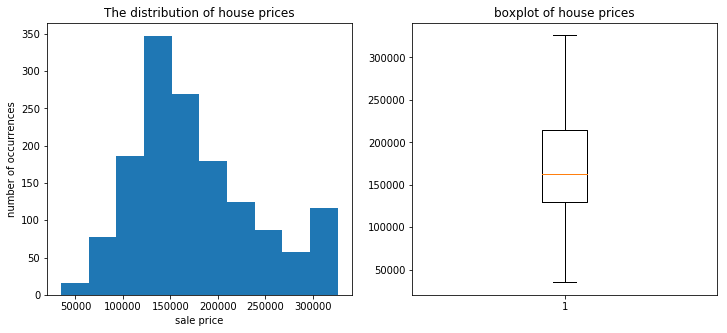

In [4]:
#try a winsorization to remove outliers and create a more normal distribution 
import scipy.stats as stats
from scipy.stats.mstats import winsorize

saleprice_winsor = winsorize(hp["saleprice"], (0, 0.05))

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.hist(saleprice_winsor)
plt.title("The distribution of house prices")
plt.xlabel("sale price")
plt.ylabel("number of occurrences")

plt.subplot(1, 2, 2)
plt.boxplot(saleprice_winsor)
plt.title("boxplot of house prices")

plt.show()

In [5]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(saleprice_winsor)
norm_stats = normaltest(saleprice_winsor)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 127.16879626197489 and p value is 0.0
Normality test statistics is 104.86701931527972 and p value is 1.692061285416133e-23


Even though the target variable is not normally distributed according to the two normality tests, the distribution looks closer to normal so I will use it as the new target variable. 

In [6]:
#add to data frame
hp['wins_saleprice'] = saleprice_winsor

In [7]:
#examine dataset
hp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
id                1460 non-null int64
mssubclass        1460 non-null int64
mszoning          1460 non-null object
lotfrontage       1201 non-null float64
lotarea           1460 non-null int64
street            1460 non-null object
alley             91 non-null object
lotshape          1460 non-null object
landcontour       1460 non-null object
utilities         1460 non-null object
lotconfig         1460 non-null object
landslope         1460 non-null object
neighborhood      1460 non-null object
condition1        1460 non-null object
condition2        1460 non-null object
bldgtype          1460 non-null object
housestyle        1460 non-null object
overallqual       1460 non-null int64
overallcond       1460 non-null int64
yearbuilt         1460 non-null int64
yearremodadd      1460 non-null int64
roofstyle         1460 non-null object
roofmatl          1460 non-null object
exte

In order to better visualize and clean the variables I am going to break them down based off whether they are discrete or continuous variables. I will further break down the discrete variables into numeric and non-numeric categories. 

In [8]:
#create list of discrete columns, one numerically discrete and one not, and continuous columns

hp_disc = hp.loc[:, ['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 
             'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl',
             'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
             'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair',
             'electrical', 'kitchenqual', 'functional', 'fireplaces', 'garagetype', 'garagefinish', 'garagequal',
             'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition']]

hp_cat = hp.loc[:, ['overallqual', 'overallcond', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
                    'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'mosold', 'yrsold']]

hp_cont = hp.loc[:, ['mssubclass', 'lotfrontage', 'lotarea', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 
                     'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 
                     'garageyrblt', 'garagearea', 'wooddecksf','openporchsf', 'threessnporch', 'screenporch', 'poolarea', 
                     'miscval', 'wins_saleprice']]

In [9]:
#Create a dictionary for discrete variables, non-numeric
list1 = hp_disc[0:]
list2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
         32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
hp_disc_dict = dict( zip( list1, list2))
print(hp_disc_dict)

{'mszoning': 1, 'street': 2, 'alley': 3, 'lotshape': 4, 'landcontour': 5, 'utilities': 6, 'lotconfig': 7, 'landslope': 8, 'neighborhood': 9, 'condition1': 10, 'condition2': 11, 'bldgtype': 12, 'housestyle': 13, 'roofstyle': 14, 'roofmatl': 15, 'exterior1st': 16, 'exterior2nd': 17, 'masvnrtype': 18, 'exterqual': 19, 'extercond': 20, 'foundation': 21, 'bsmtqual': 22, 'bsmtcond': 23, 'bsmtexposure': 24, 'bsmtfintype1': 25, 'bsmtfintype2': 26, 'heating': 27, 'heatingqc': 28, 'centralair': 29, 'electrical': 30, 'kitchenqual': 31, 'functional': 32, 'fireplaces': 33, 'garagetype': 34, 'garagefinish': 35, 'garagequal': 36, 'garagecond': 37, 'paveddrive': 38, 'poolqc': 39, 'fence': 40, 'miscfeature': 41, 'saletype': 42}


In [10]:
#Create a dictionary for categorical variables, numeric
list1 = hp_cat[0:]
list2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
hp_cat_dict = dict( zip( list1, list2))
print(hp_cat_dict)

{'overallqual': 1, 'overallcond': 2, 'bsmtfullbath': 3, 'bsmthalfbath': 4, 'fullbath': 5, 'halfbath': 6, 'bedroomabvgr': 7, 'kitchenabvgr': 8, 'totrmsabvgrd': 9, 'fireplaces': 10, 'garagecars': 11, 'mosold': 12, 'yrsold': 13}


In [11]:
#Create a dictionary for continuous variables
list1 = hp_cont[0:]
list2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
hp_cont_dict = dict( zip( list1, list2))
print(hp_cont_dict)

{'mssubclass': 1, 'lotfrontage': 2, 'lotarea': 3, 'yearbuilt': 4, 'yearremodadd': 5, 'masvnrarea': 6, 'bsmtfinsf1': 7, 'bsmtfinsf2': 8, 'bsmtunfsf': 9, 'totalbsmtsf': 10, 'firstflrsf': 11, 'secondflrsf': 12, 'lowqualfinsf': 13, 'grlivarea': 14, 'garageyrblt': 15, 'garagearea': 16, 'wooddecksf': 17, 'openporchsf': 18, 'threessnporch': 19, 'screenporch': 20, 'poolarea': 21, 'miscval': 22, 'wins_saleprice': 23}


The lists I just created will be used to iterate over and visualize the variables. I am choosing to only clean up the continuous variables so first I'll visualize the discrete variables and see which ones appear to have significance with the target variable. 

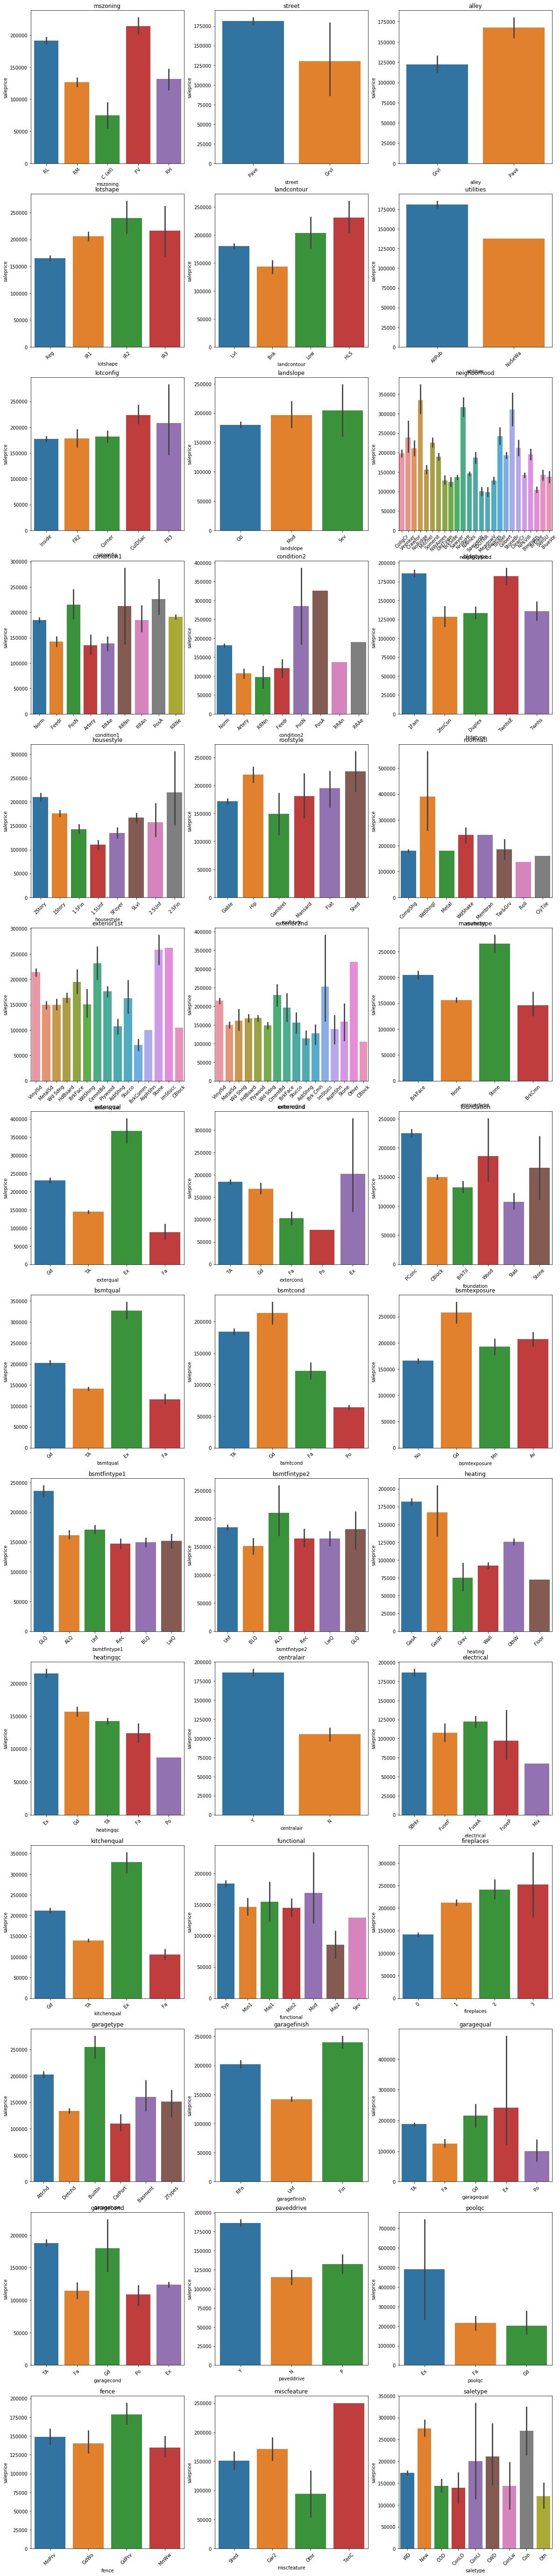

In [12]:
#visualizing discrete, non-numeric variables
plt.figure(figsize=(20,100))

for variable, i in hp_disc_dict.items():
                     plt.subplot(14, 3, i)
                     sns.barplot(hp_disc[variable], hp['saleprice'])
                     plt.xticks(rotation = 45)
                     plt.title(variable)


plt.show()

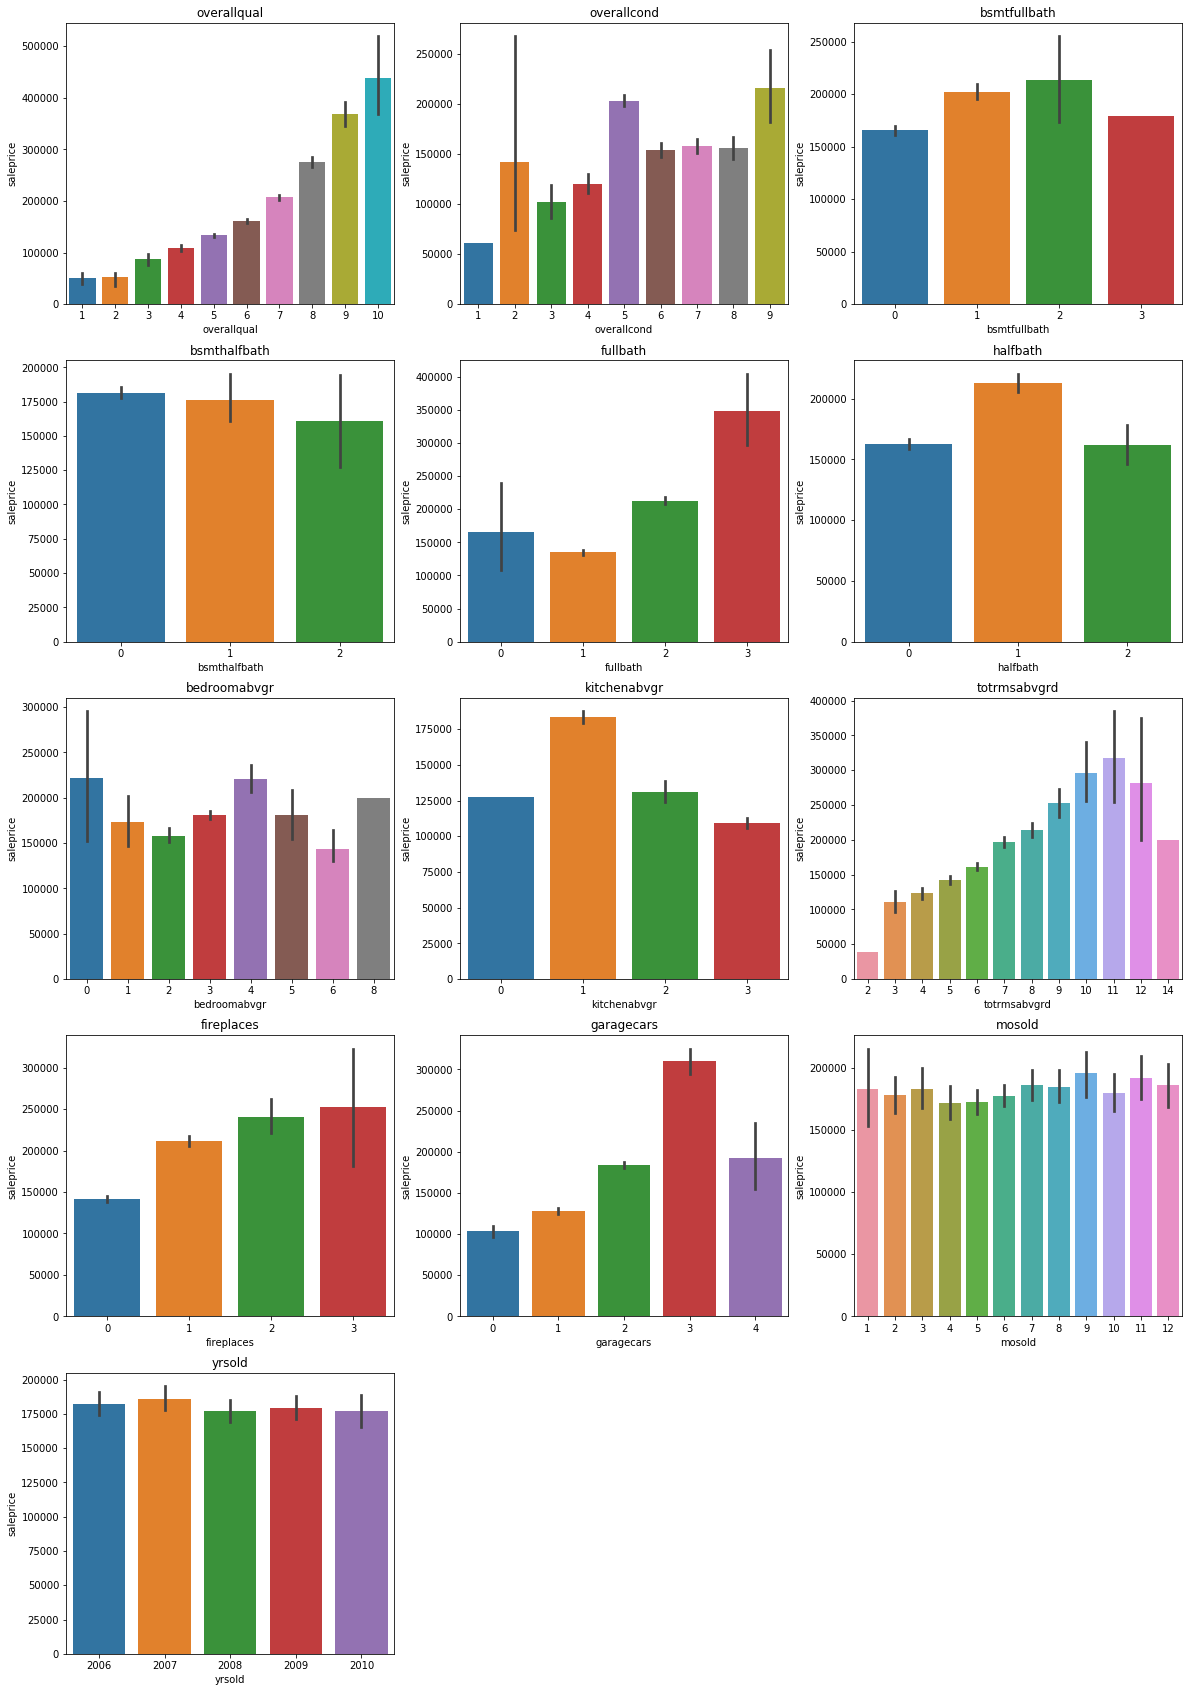

In [13]:
#visualizing discrete, numeric variables
plt.figure(figsize=(20,30))

for variable, i in hp_cat_dict.items():
                     plt.subplot(5, 3, i)
                     sns.barplot(hp_cat[variable], hp['saleprice'])
                     plt.title(variable)


plt.show()

Looking at the discrete variables, garagecars, fullbath, and overallqual seem to have the biggest effect on saleprice.

### Data Cleaning and Exploration
#### Continuous variables 

In [14]:
#find null values
hp_cont.isnull().sum()*100/hp_cont.isnull().count()

mssubclass         0.000000
lotfrontage       17.739726
lotarea            0.000000
yearbuilt          0.000000
yearremodadd       0.000000
masvnrarea         0.547945
bsmtfinsf1         0.000000
bsmtfinsf2         0.000000
bsmtunfsf          0.000000
totalbsmtsf        0.000000
firstflrsf         0.000000
secondflrsf        0.000000
lowqualfinsf       0.000000
grlivarea          0.000000
garageyrblt        5.547945
garagearea         0.000000
wooddecksf         0.000000
openporchsf        0.000000
threessnporch      0.000000
screenporch        0.000000
poolarea           0.000000
miscval            0.000000
wins_saleprice     0.000000
dtype: float64

In [15]:
#fill in missing values with averages
#I've chosen to ignore the garage year built variable
hp_cont['lotfrontage'].fillna(hp_cont['lotfrontage'].mean(), inplace = True)
hp_cont['masvnrarea'].fillna(hp_cont['masvnrarea'].mean(), inplace = True)

In [16]:
#look for abnormal values
for column_name in hp_cont.columns:
    print("Unique values in column {} are: {}".format(column_name, hp_cont[column_name].unique()))

Unique values in column mssubclass are: [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
Unique values in column lotfrontage are: [ 65.          80.          68.          60.          84.
  85.          75.          70.04995837  51.          50.
  70.          91.          72.          66.         101.
  57.          44.         110.          98.          47.
 108.         112.          74.         115.          61.
  48.          33.          52.         100.          24.
  89.          63.          76.          81.          95.
  69.          21.          32.          78.         121.
 122.          40.         105.          73.          77.
  64.          94.          34.          90.          55.
  88.          82.          71.         120.         107.
  92.         134.          62.          86.         141.
  97.          54.          41.          79.         174.
  99.          67.          83.          43.         103.
  93.          30.         129.         140. 

Doesn't appear to be any strange or blank values present in our continuous variables. 

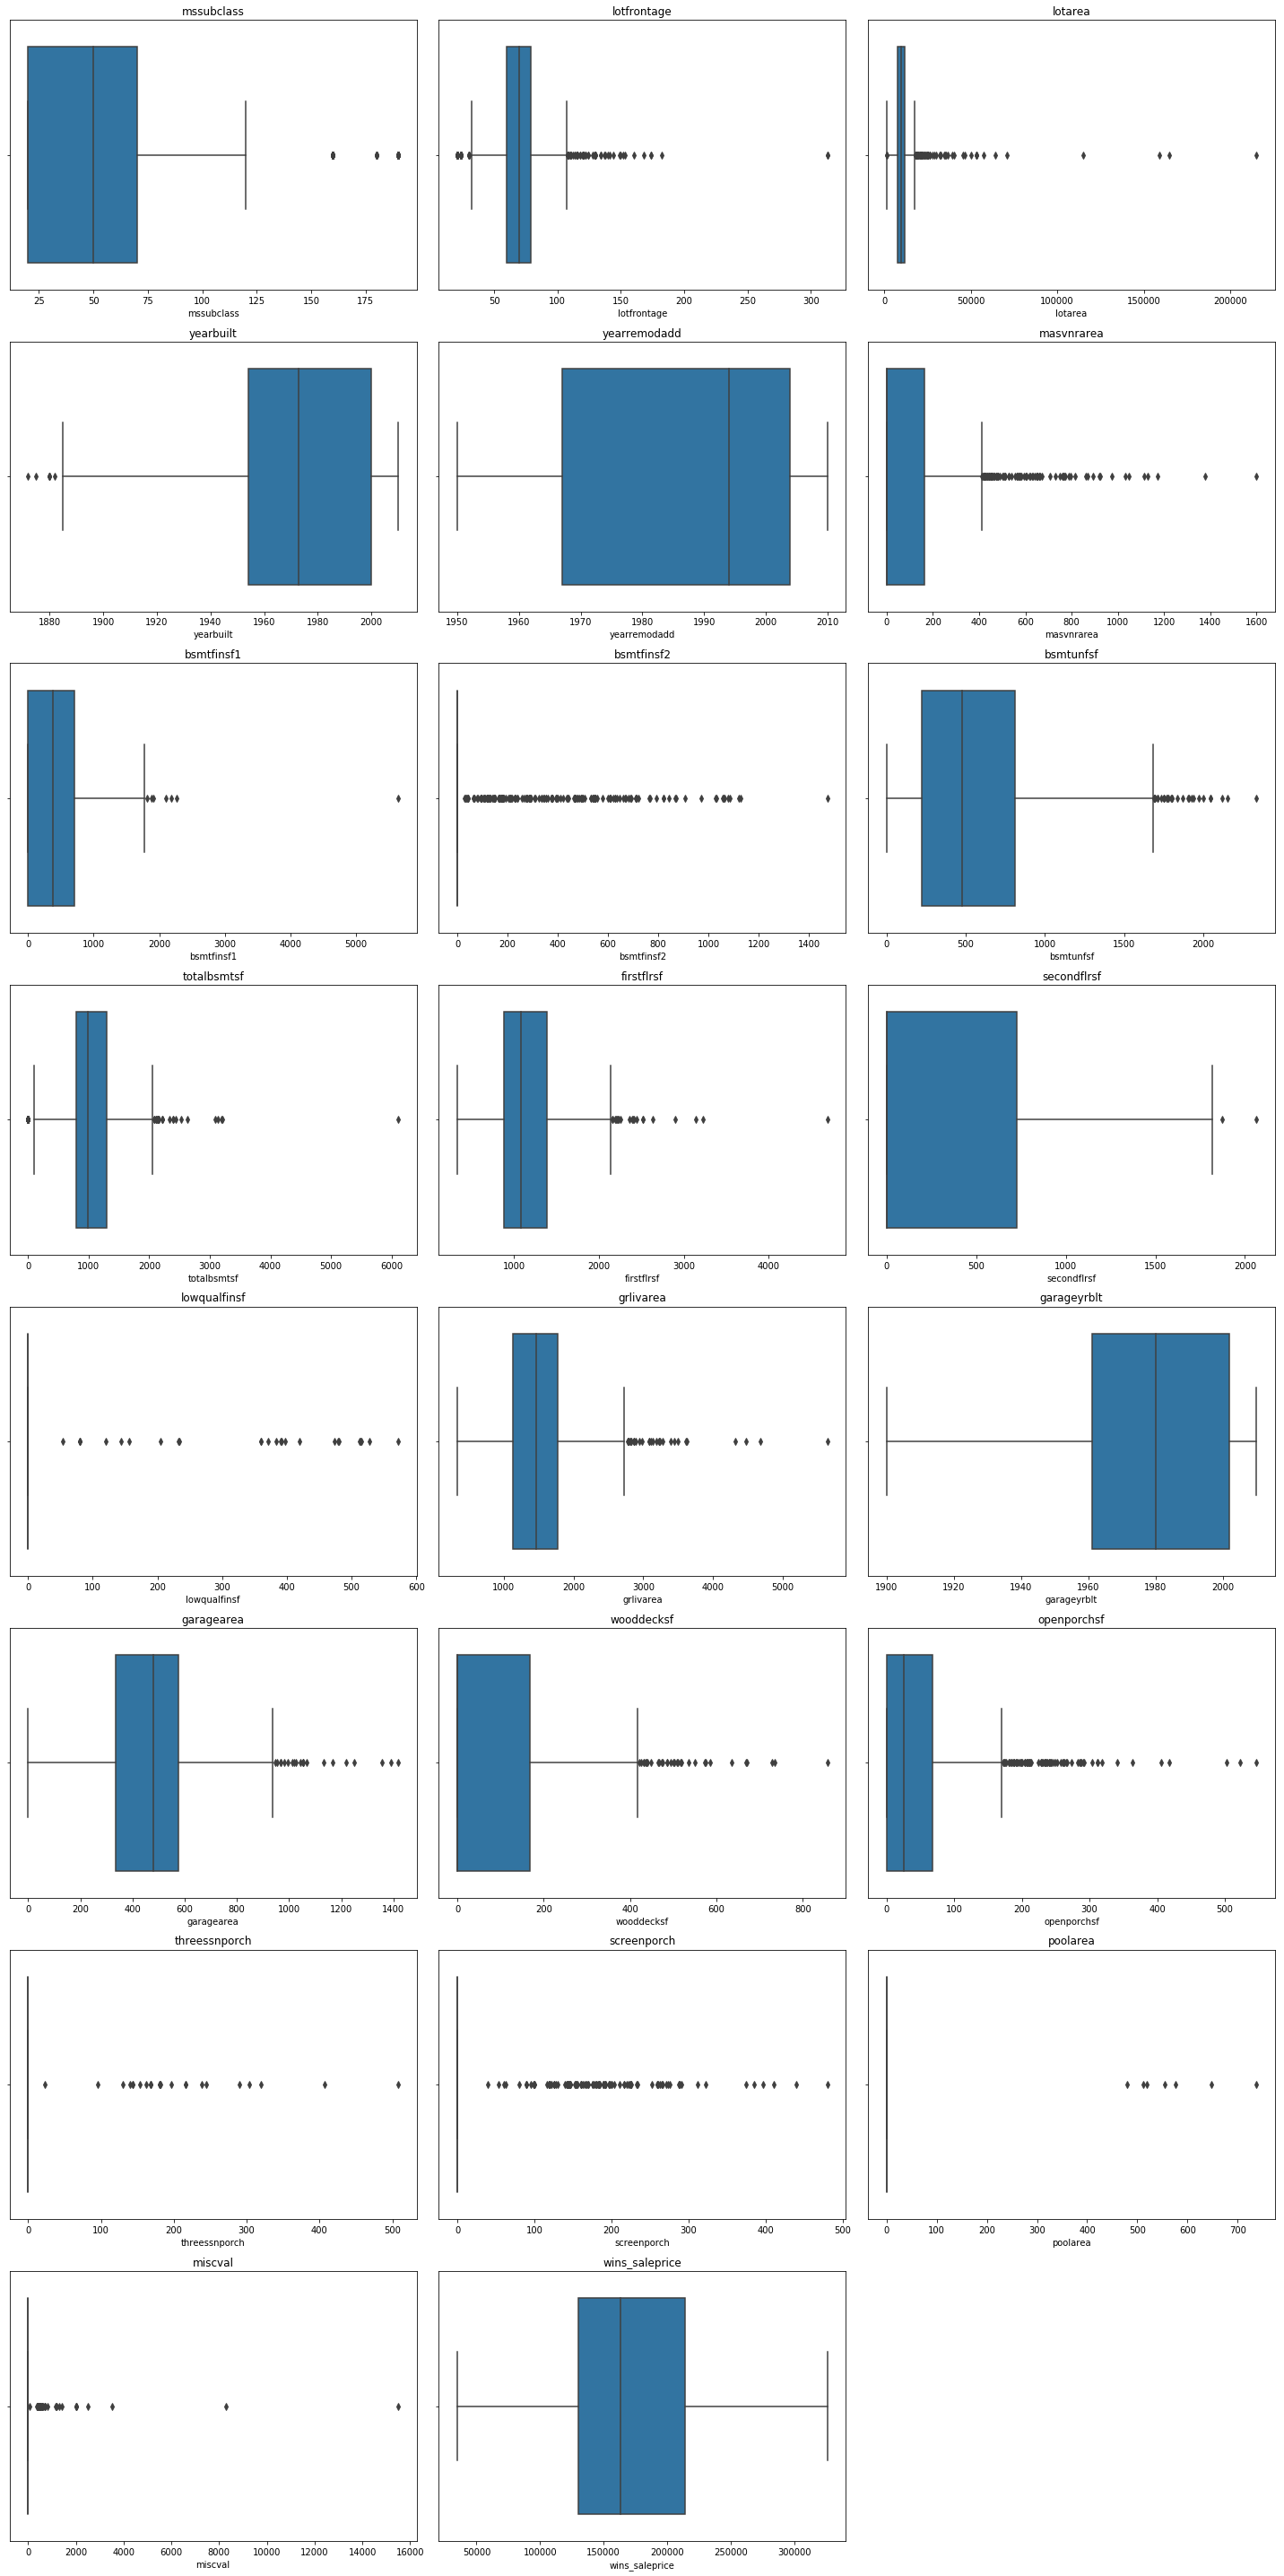

In [17]:
plt.figure(figsize=(20,40))

for variable, i in hp_cont_dict.items():
                     plt.subplot(8, 3, i)
                     sns.boxplot(hp_cont[variable])
                     plt.title(variable)

plt.tight_layout()
plt.show()

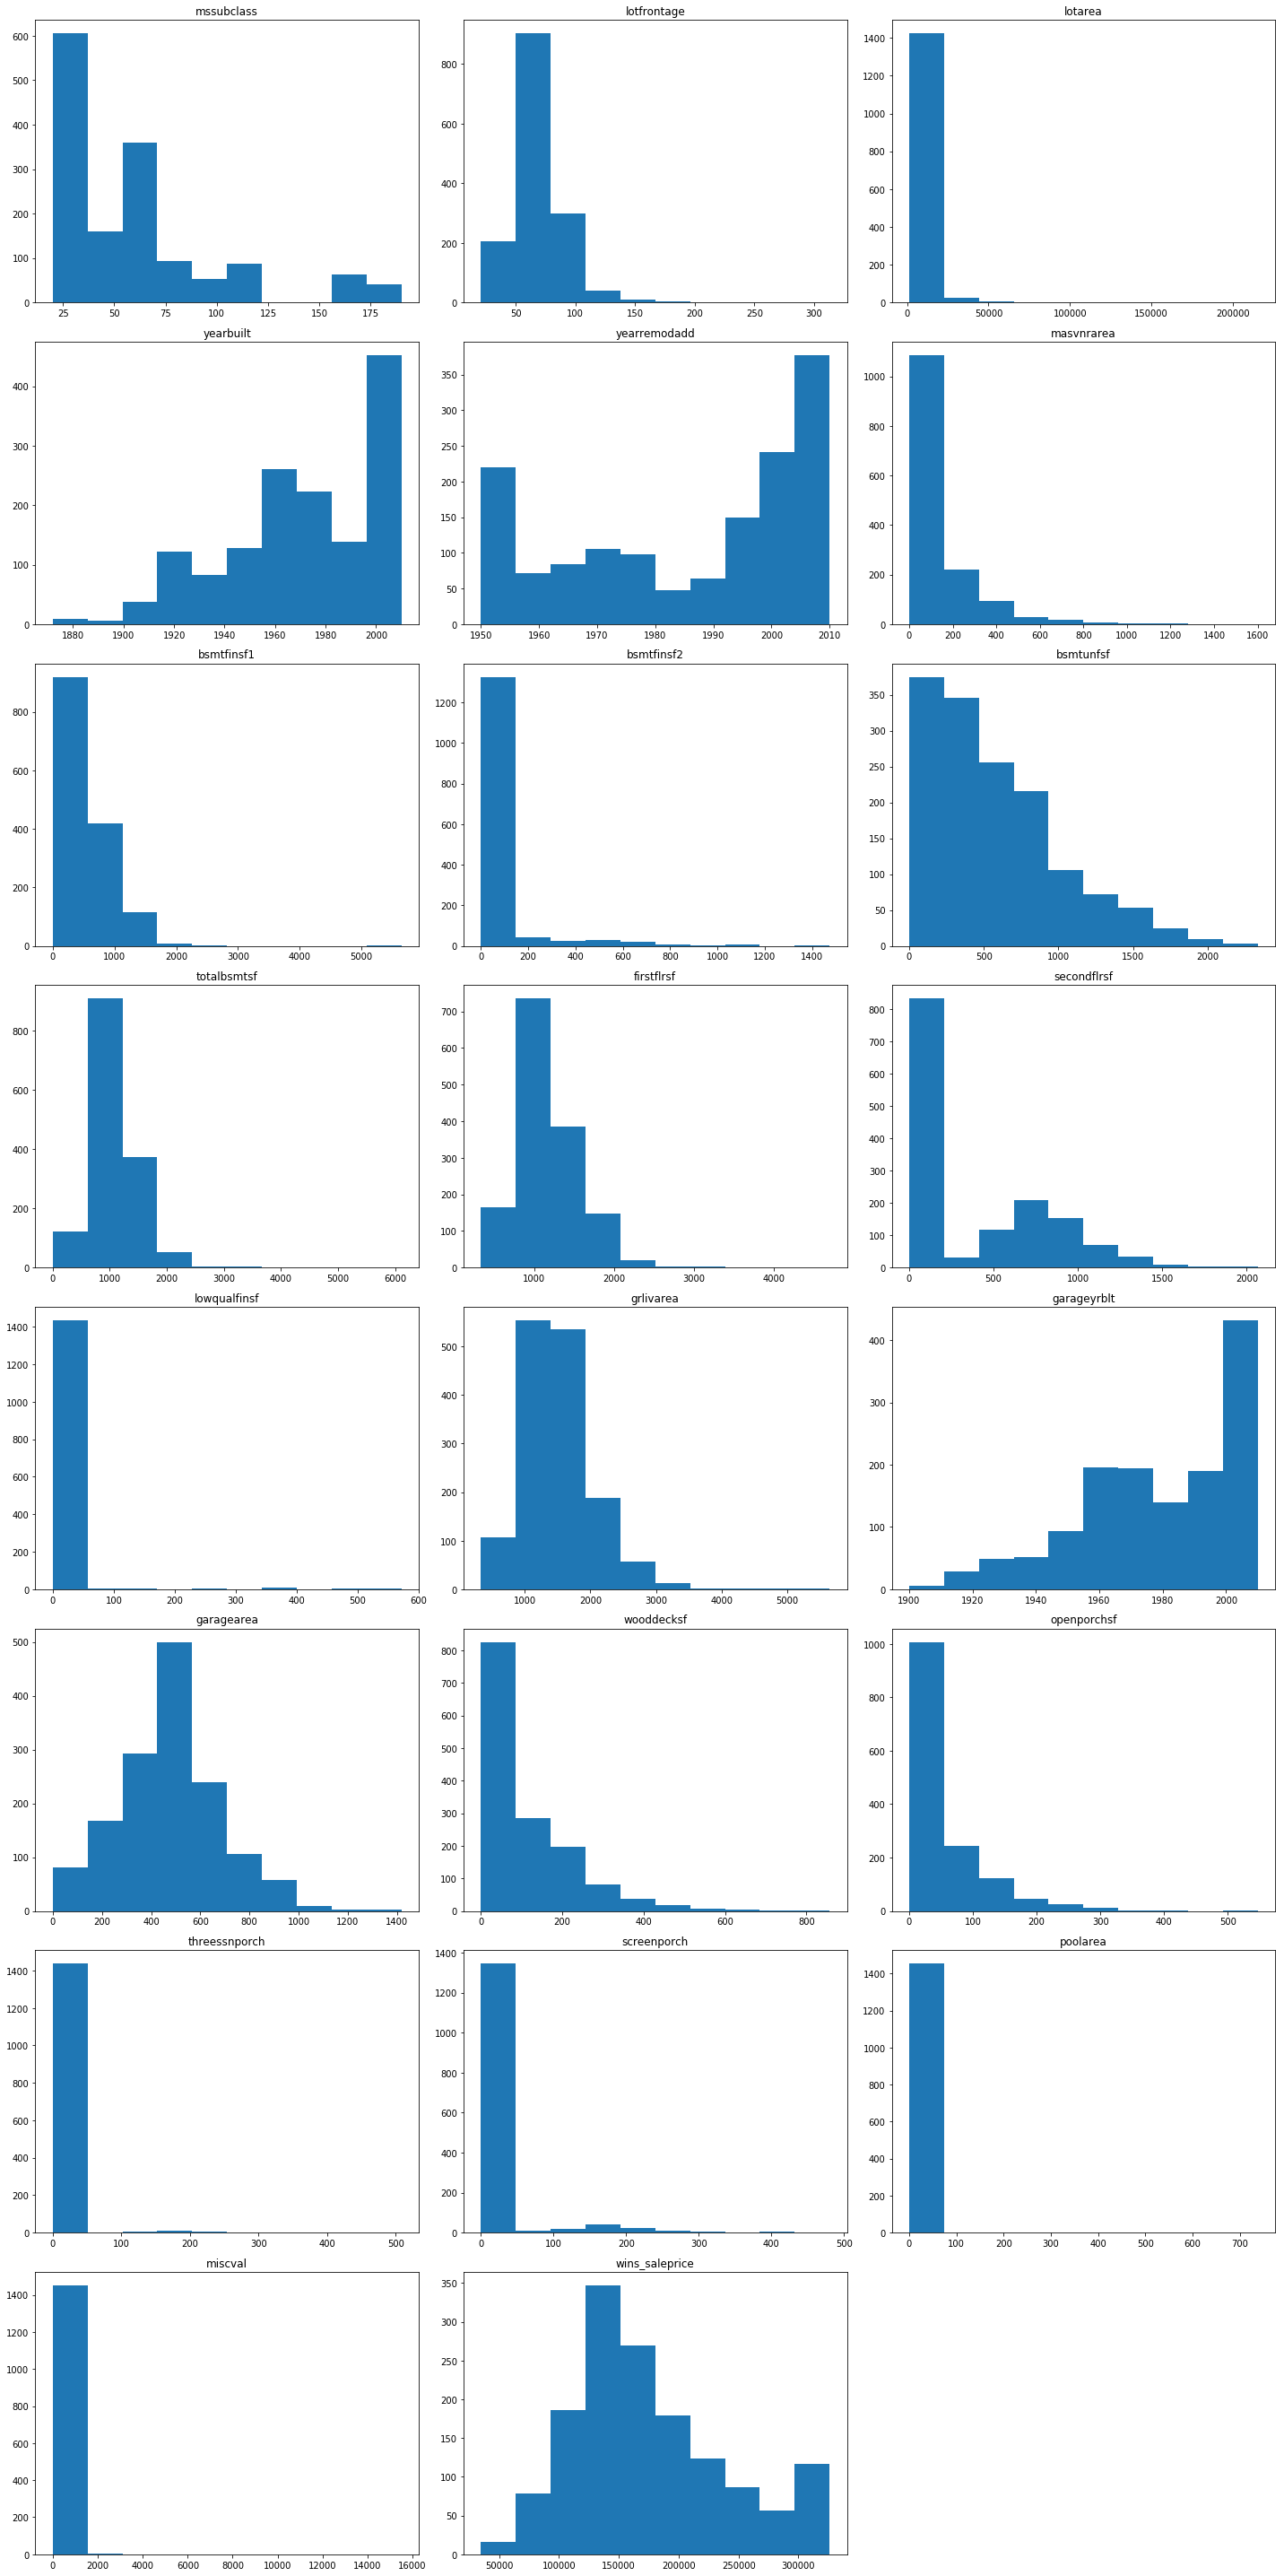

In [18]:
plt.figure(figsize=(20,40))

for variable, i in hp_cont_dict.items():
                     plt.subplot(8, 3, i)
                     plt.hist(hp_cont[variable])
                     plt.title(variable)

plt.tight_layout()
plt.show()

In [19]:
#clean up some of the variables with outliers by winsorization

hp_cont['wins_lotfrontage'] = winsorize(hp_cont['lotfrontage'], (0, 0.05))
hp_cont['wins_lotarea'] = winsorize(hp_cont['lotarea'], (0, 0.05))
hp_cont['wins_masvnrarea'] = winsorize(hp_cont['masvnrarea'], (0, 0.05))
hp_cont['wins_bsmtfinsf1'] = winsorize(hp_cont['bsmtfinsf1'], (0, 0.05))
hp_cont['wins_bsmtunfsf'] = winsorize(hp_cont['bsmtunfsf'], (0, 0.05))
hp_cont['wins_totalbsmtsf'] = winsorize(hp_cont['totalbsmtsf'], (0, 0.05))
hp_cont['wins_firstflrsf'] = winsorize(hp_cont['firstflrsf'], (0, 0.05))
hp_cont['wins_grlivarea'] = winsorize(hp_cont['grlivarea'], (0, 0.05))
hp_cont['wins_garagearea'] = winsorize(hp_cont['garagearea'], (0, 0.05))
hp_cont['wins_wooddecksf'] = winsorize(hp_cont['wooddecksf'], (0, 0.05))
hp_cont['wins_openporchsf'] = winsorize(hp_cont['openporchsf'], (0, 0.05))

In [20]:
hp_cont_wins = hp_cont.loc[:, ['wins_lotfrontage', 'wins_lotarea', 'wins_masvnrarea', 'wins_bsmtfinsf1', 'wins_totalbsmtsf', 
                               'wins_firstflrsf', 'wins_grlivarea', 'wins_garagearea', 'wins_wooddecksf','wins_openporchsf']]

list1 = hp_cont_wins[0:]
list2 = [1, 2, 3, 4, 5, 6, 7, 8]
hp_cont_wins_dict = dict( zip( list1, list2))
print(hp_cont_wins_dict)

{'wins_lotfrontage': 1, 'wins_lotarea': 2, 'wins_masvnrarea': 3, 'wins_bsmtfinsf1': 4, 'wins_totalbsmtsf': 5, 'wins_firstflrsf': 6, 'wins_grlivarea': 7, 'wins_garagearea': 8}


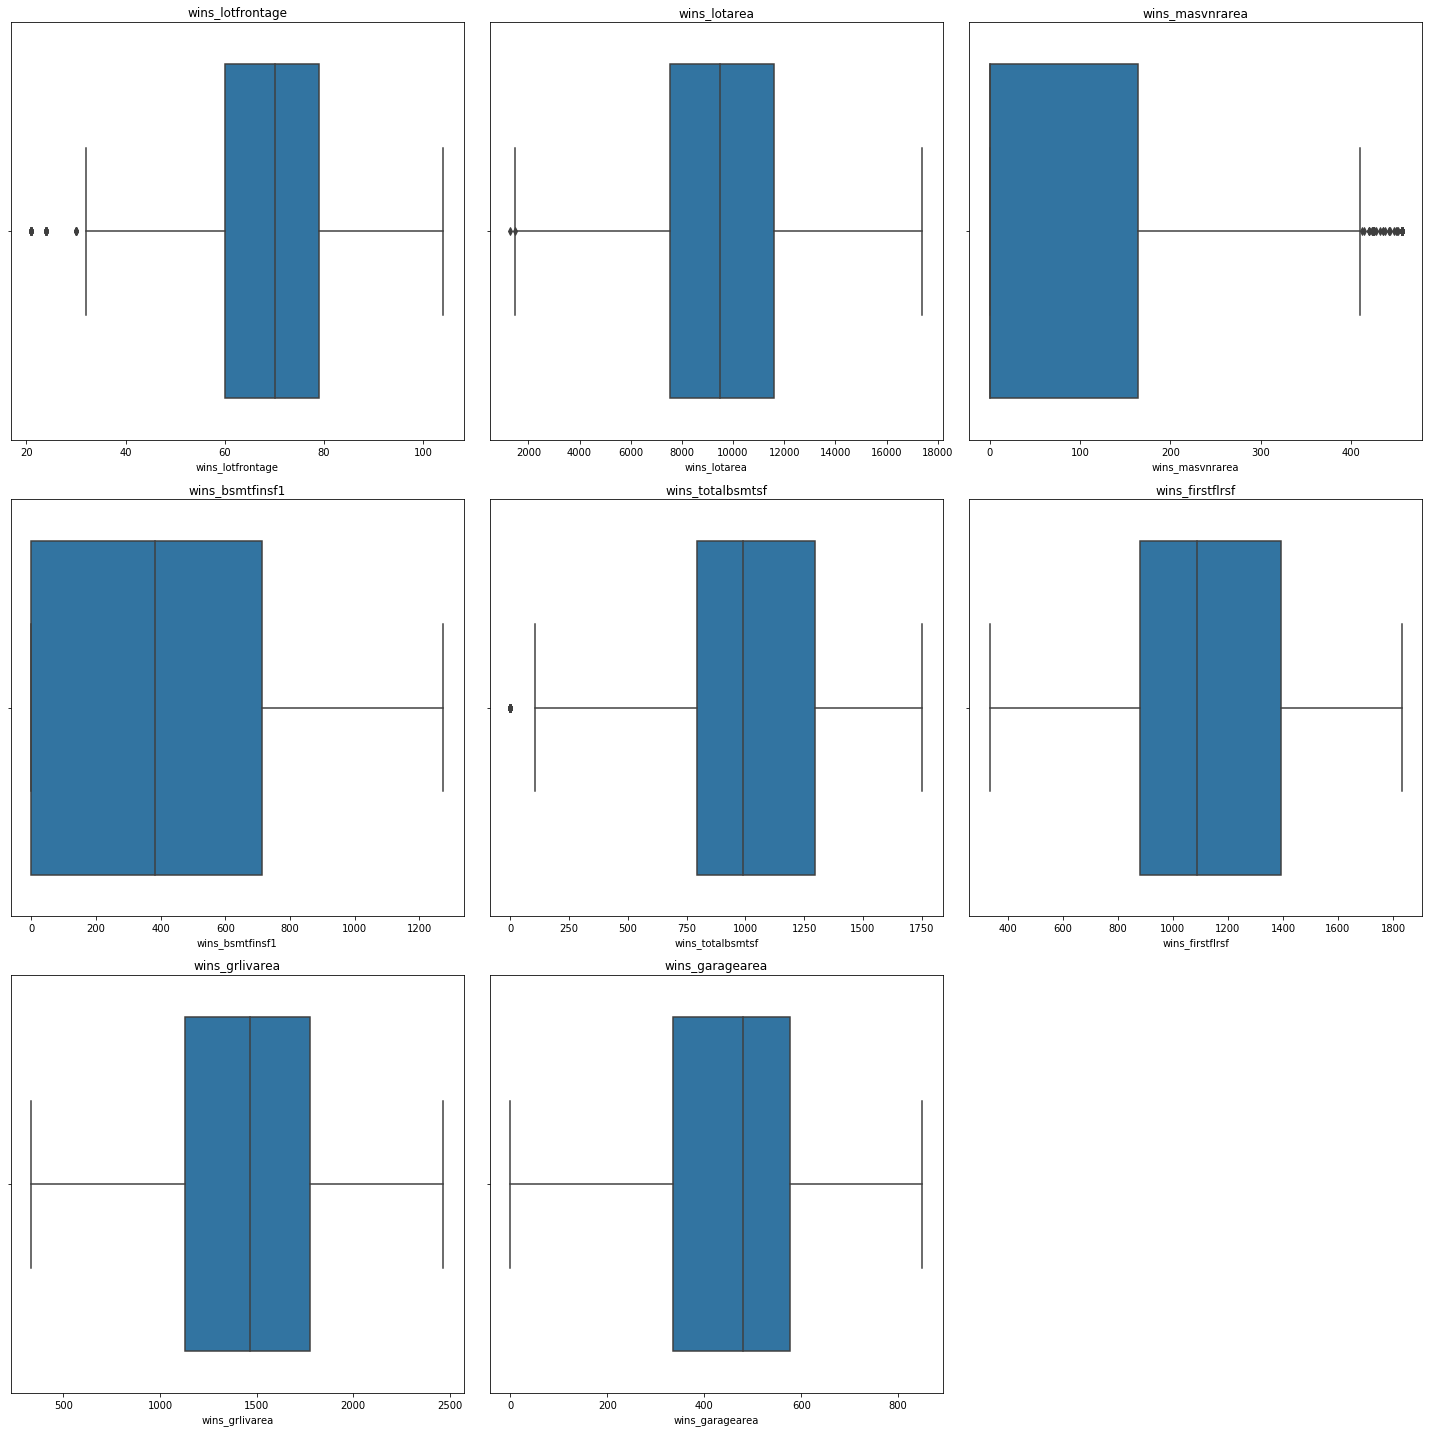

In [21]:
plt.figure(figsize=(20,20))

for variable, i in hp_cont_wins_dict.items():
                     plt.subplot(3, 3, i)
                     sns.boxplot(hp_cont_wins[variable])
                     plt.title(variable)

plt.tight_layout()
plt.show()

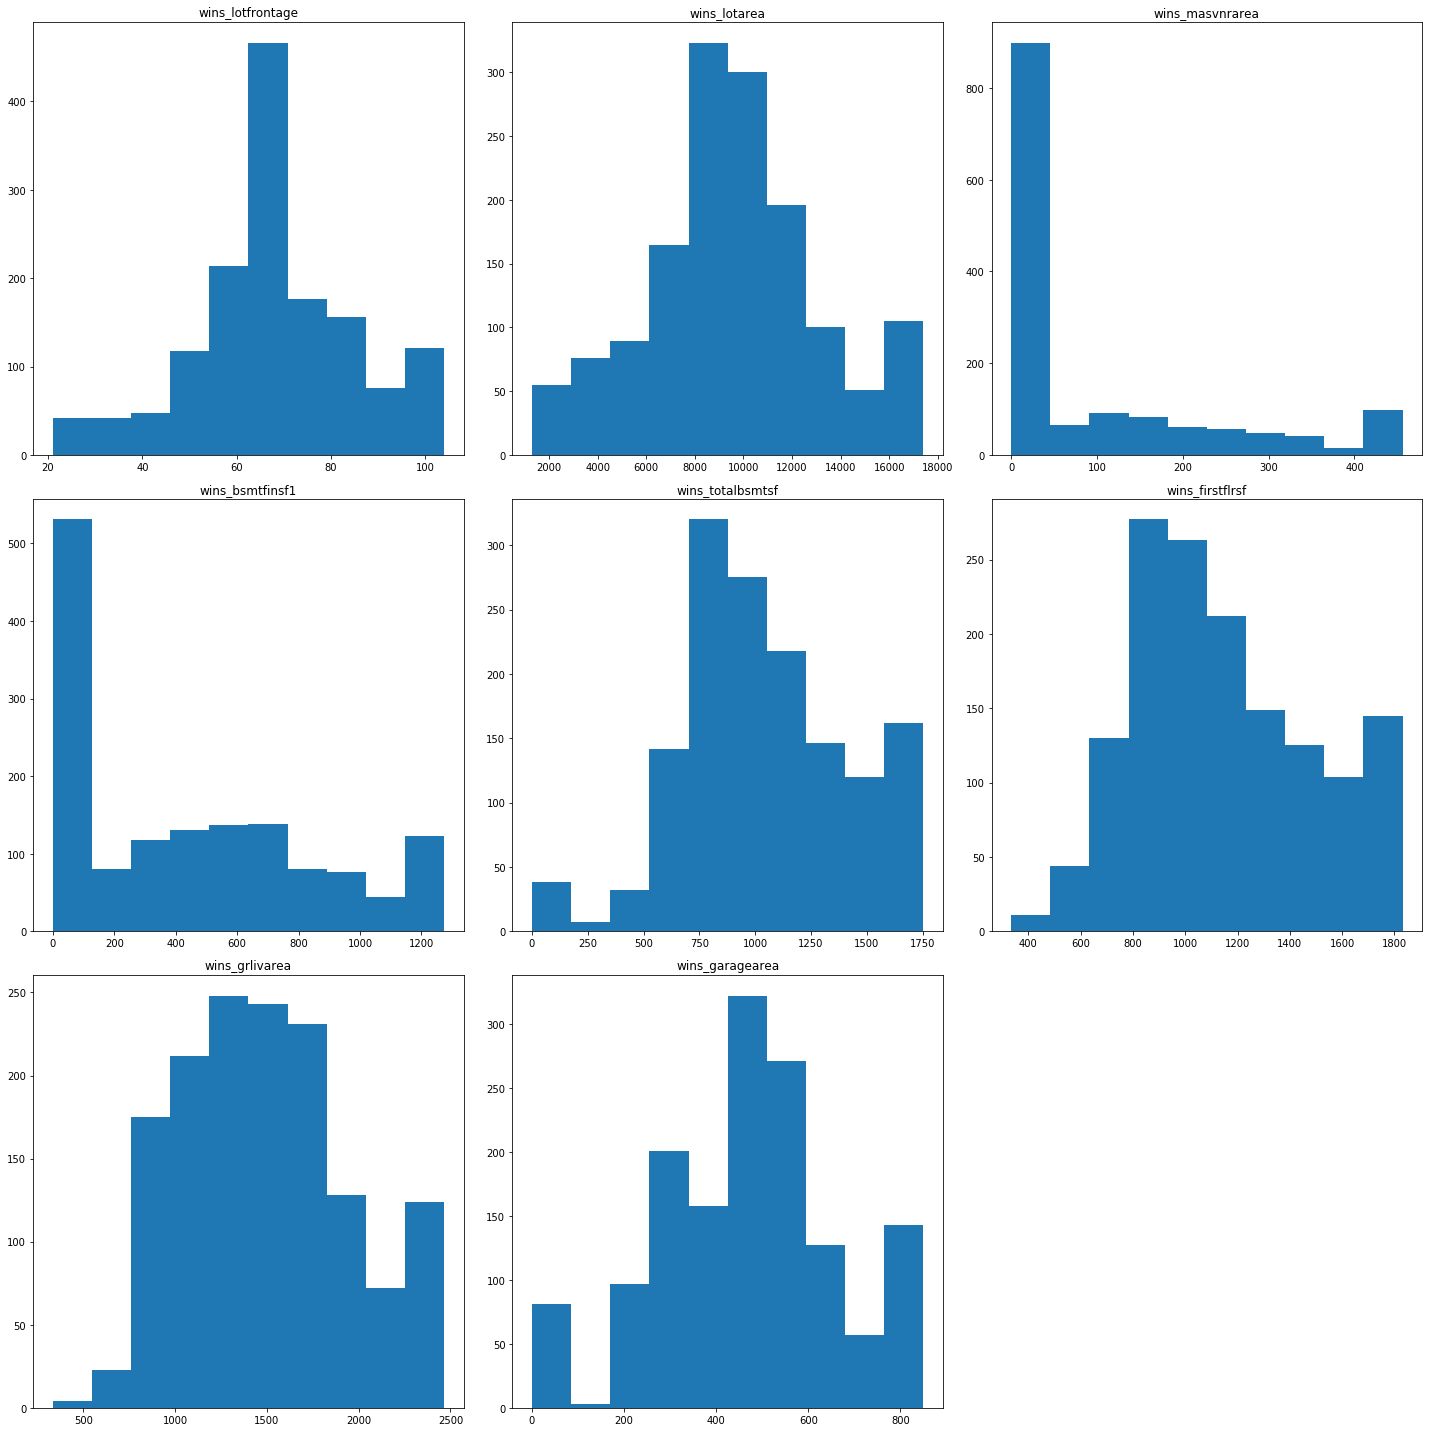

In [22]:
plt.figure(figsize=(20,20))

for variable, i in hp_cont_wins_dict.items():
                     plt.subplot(3, 3, i)
                     plt.hist(hp_cont_wins[variable])
                     plt.title(variable)

plt.tight_layout()
plt.show()

Winsorization took care of the outliers and the new variables appear to be more normally distributed. 

In [23]:
#drop unwinsorized columns for correlation 
hp_cont.drop(columns = ['lotfrontage', 'lotarea', 'masvnrarea', 'bsmtfinsf1', 'bsmtunfsf', 'totalbsmtsf', 
                         'firstflrsf', 'grlivarea', 'garagearea', 'wooddecksf', 'openporchsf'], inplace = True)

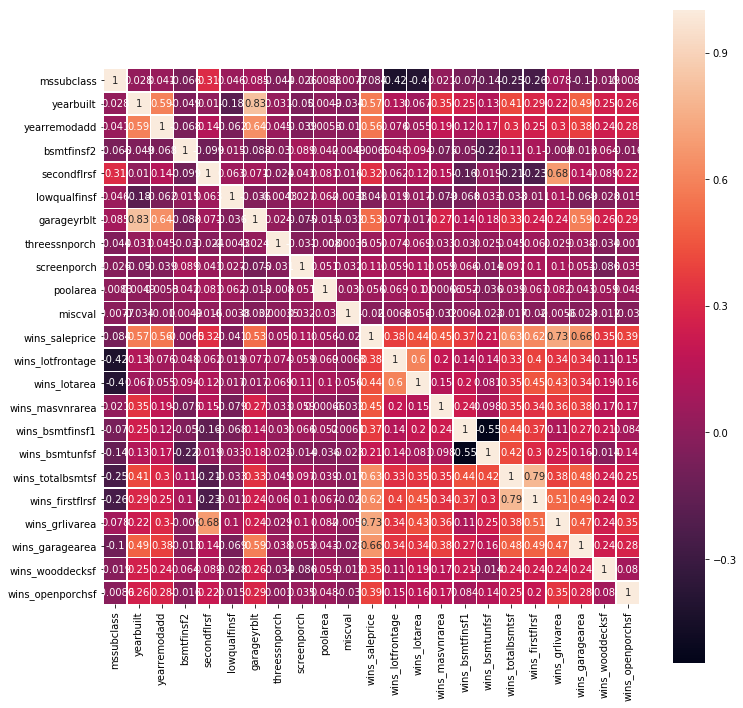

In [24]:
cor_map = hp_cont.corr()

fig, ax = plt.subplots(figsize = (12, 12))
sns.heatmap(cor_map, square=True, annot=True, linewidths=.5, ax = ax)

{'mssubclass': 1, 'yearbuilt': 2, 'yearremodadd': 3, 'bsmtfinsf2': 4, 'secondflrsf': 5, 'lowqualfinsf': 6, 'garageyrblt': 7, 'threessnporch': 8, 'screenporch': 9, 'poolarea': 10, 'miscval': 11, 'wins_saleprice': 12, 'wins_lotfrontage': 13, 'wins_lotarea': 14, 'wins_masvnrarea': 15, 'wins_bsmtfinsf1': 16, 'wins_bsmtunfsf': 17, 'wins_totalbsmtsf': 18, 'wins_firstflrsf': 19, 'wins_grlivarea': 20, 'wins_garagearea': 21, 'wins_wooddecksf': 22, 'wins_openporchsf': 23}


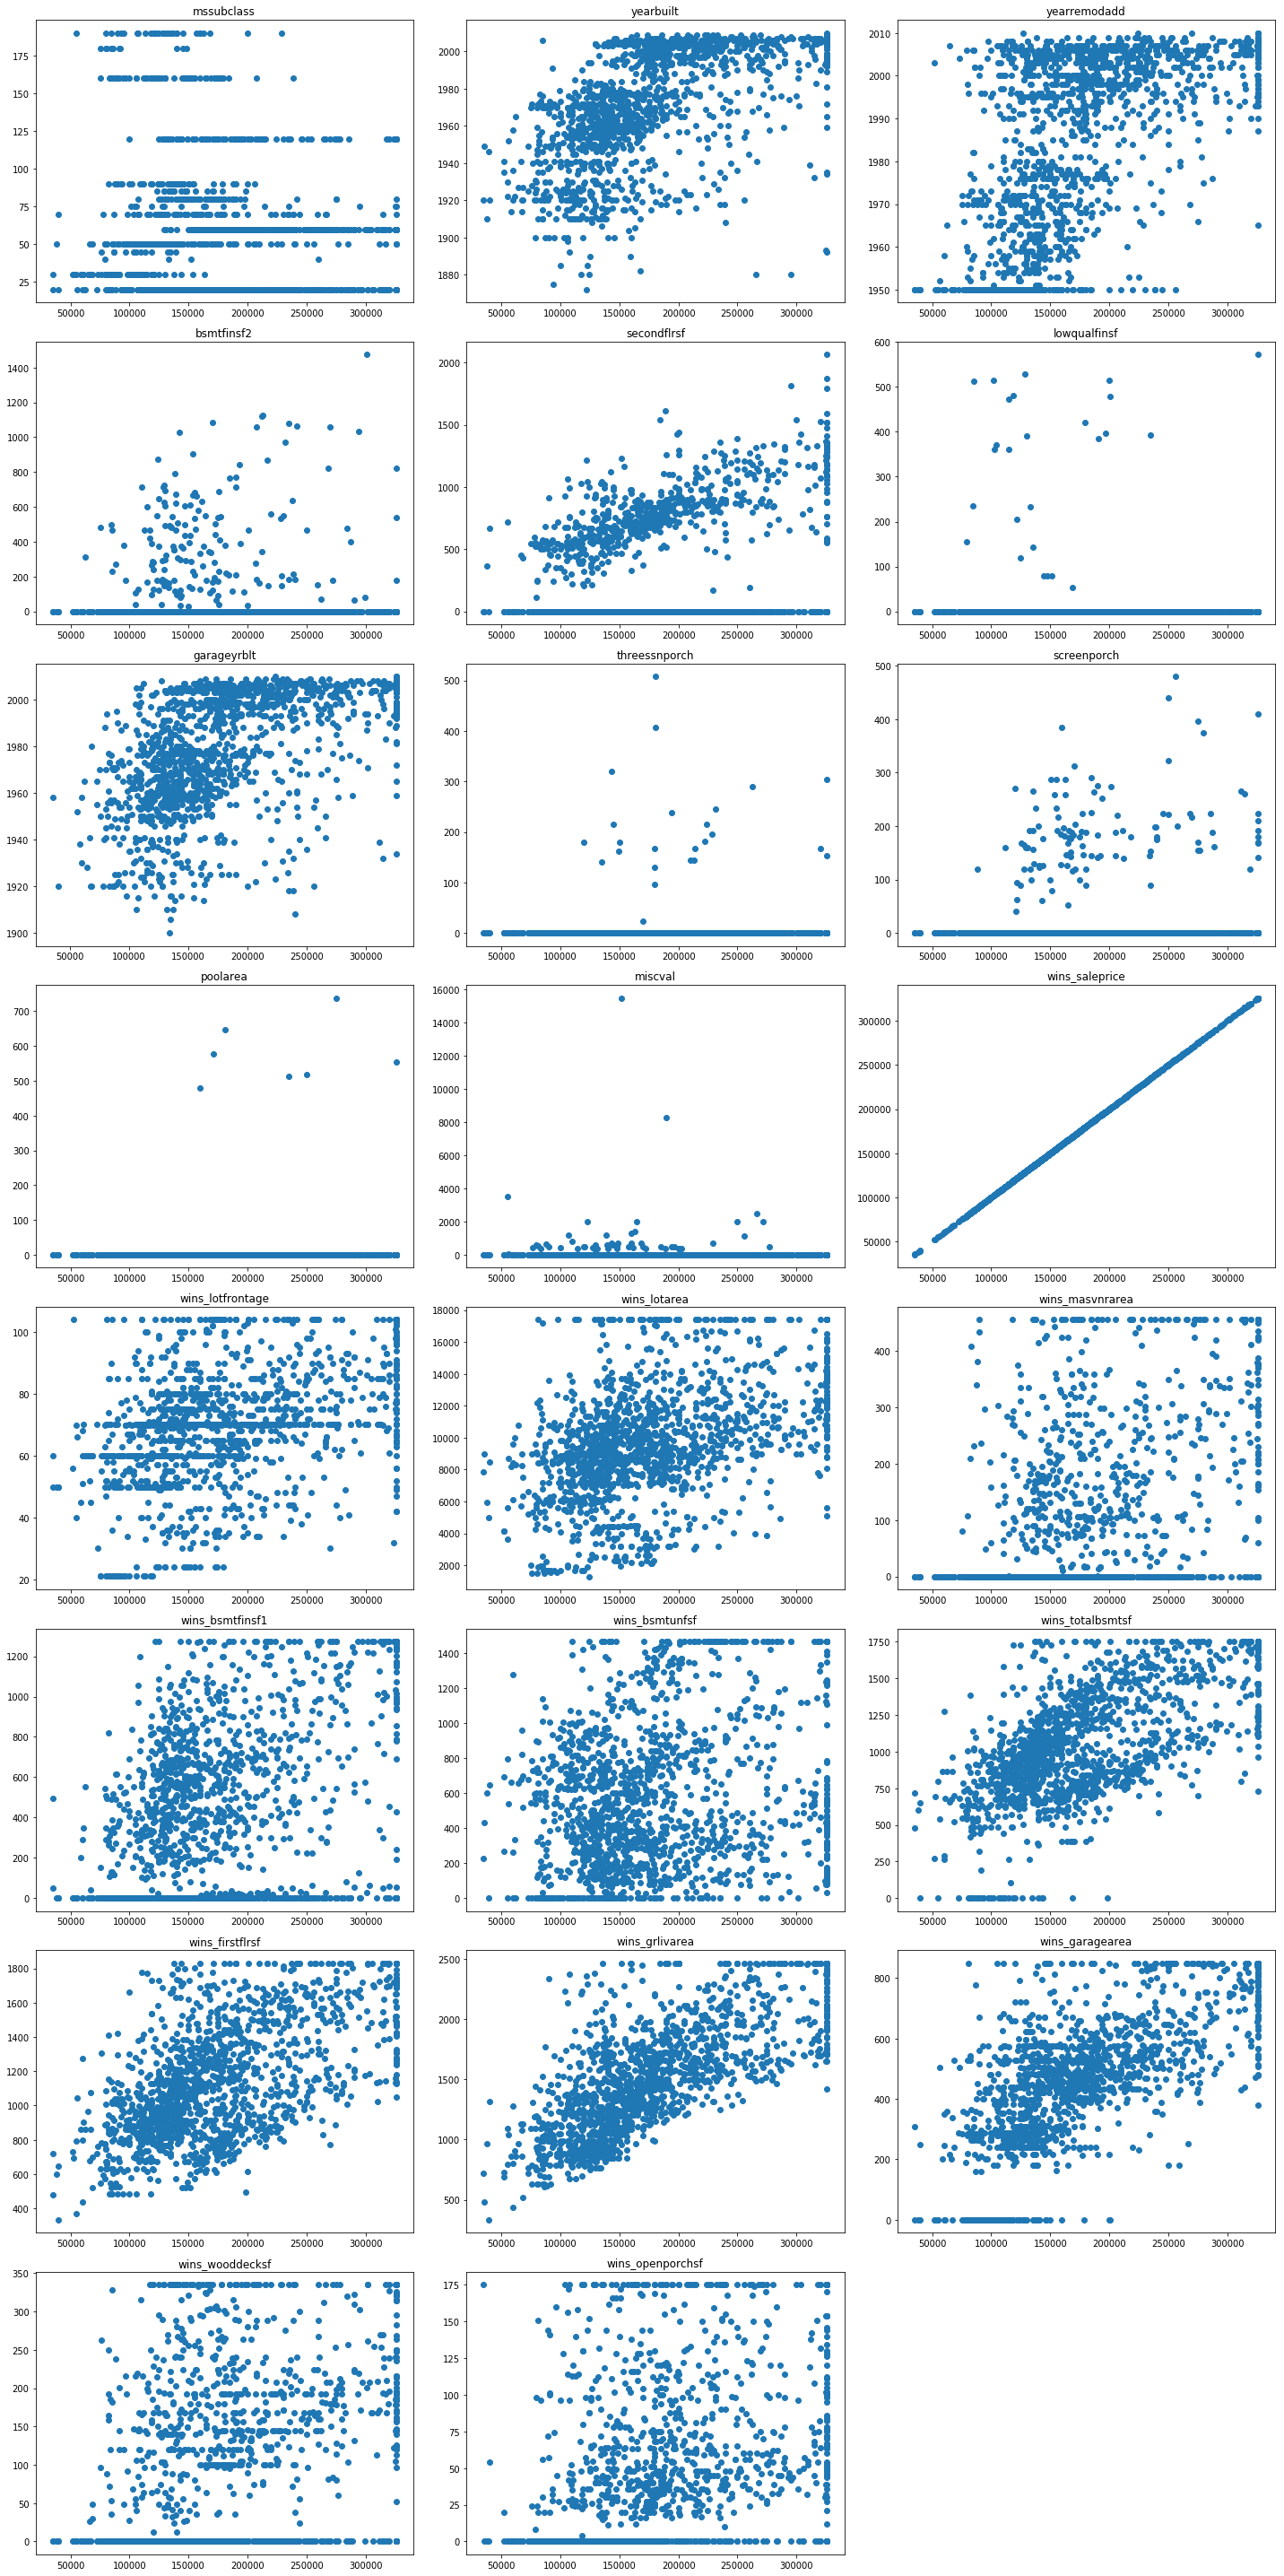

In [25]:
list1 = hp_cont[0:]
list2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
hp_cont2_dict = dict( zip( list1, list2))
print(hp_cont2_dict)

plt.figure(figsize=(20,40))

for variable, i in hp_cont2_dict.items():
                     plt.subplot(8, 3, i)
                     plt.scatter(x = hp_cont['wins_saleprice'], y = hp_cont[variable])
                     plt.title(variable)

plt.tight_layout()
plt.show()

Looking at all the continuous variables that have been cleaned, it appears that the most correlated variables to saleprice are garagearea, grlivarea, firstflrsf, and totalbsmtsf. We will use these four variables along with the other variables we found previously to build our regression model. 

In [26]:
#add winsorized variables to original dataframe
hp['wins_grlivarea'] = winsorize(hp['grlivarea'], (0, 0.05))
hp['wins_garagearea'] = winsorize(hp['garagearea'], (0, 0.05))
hp['wins_totalbsmtsf'] = winsorize(hp['totalbsmtsf'], (0, 0.05))
hp['wins_firstflrsf'] = winsorize(hp['firstflrsf'], (0, 0.05))

## Features Engineering

It seems that there would be a correlation between firstflrsf, totatbsmtsf and secondflrsf. These also all appear to be correlated with saleprice. I want to create a new feature, totalsf, that combines these three variables. Also I want to create dummy variables for the centralair and street variables. 

{'whiskers': [<matplotlib.lines.Line2D at 0x11bfb357fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x11bfb2922e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x11bfb357630>],
 'medians': [<matplotlib.lines.Line2D at 0x11bfb292978>],
 'fliers': [<matplotlib.lines.Line2D at 0x11bfb292cc0>],
 'means': []}

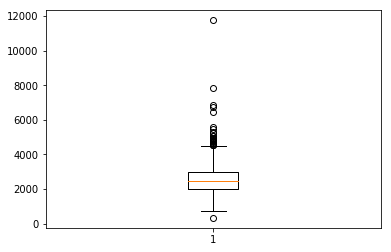

In [27]:
hp['totalsf'] = hp['secondflrsf'] + hp['firstflrsf'] + hp['totalbsmtsf']

plt.boxplot(hp.totalsf)

{'whiskers': [<matplotlib.lines.Line2D at 0x11bfd897a58>,
 'caps': [<matplotlib.lines.Line2D at 0x11bfd897e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x11bfd897630>],
 'medians': [<matplotlib.lines.Line2D at 0x11bfd8987b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x11bfd898b00>],
 'means': []}

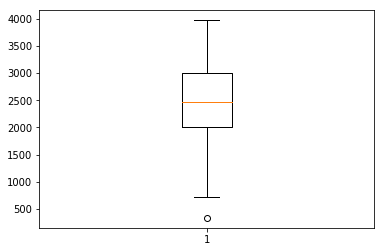

In [28]:
hp['wins_totalsf'] = winsorize(hp['totalsf'], (0, 0.05))

plt.boxplot(hp.wins_totalsf)

In [29]:
hp["dummies_street"] = pd.get_dummies(hp.street, drop_first=True)
hp["dummies_centralair"] = pd.get_dummies(hp.centralair, drop_first=True)

## Begin Modelling

In [30]:
# Build first linear regression model
Y = hp['wins_saleprice']
 
X = hp[['overallqual', 'fullbath', 'garagecars', 'wins_totalsf', 'wins_grlivarea', 'wins_garagearea']]

lrm = linear_model.LinearRegression()

lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [1.89270721e+04 2.17297877e+03 7.57504941e+03 3.75293684e+01
 6.19059535e+00 3.12267378e+01]

Intercept: 
 -74555.93779277764


In [31]:
import statsmodels.api as sm

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         wins_saleprice   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     1148.
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:58:27   Log-Likelihood:                -16990.
No. Observations:                1460   AIC:                         3.399e+04
Df Residuals:                    1453   BIC:                         3.403e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -7.456e+04   3335.341    -22.353      0.000   -8.11e+04    -6.8e+04
overallqual      1.893e+04    773.465     24.470      0.000    1.74e+04    2.04e+04
fullbath         2172.9788   1789.431      1.214      0.225   -1337.165    5683.122
garagecars       7575.0494   2264.649      3.345      0.001    3132.718     1.2e+04
wins_totalsf       37.5294      2.261     16.599      0.000      33.094      41.964
wins_grlivarea      6.1906      3.269      1.894      0.058      -0.222      12.603
wins_garagearea    31.2267      8.213      3.802      0.000      15.116      47.337
==============================================================================
Omnibus:                      150.052   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              501.367
Skew:                          -0.487   Prob(JB):                    1.35e-109
Kurtosis:                       5.700   Cond. No.                     1.45e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The first model seems to be performing fairly well with an adjusted R-squared value of 0.816. Let's try another by adding some variables and removing a couple. 

In [32]:
# Second model - add yearbuilt and dummies_centralair, remove fullbath and garagecars
Y = hp['wins_saleprice']

# X is the feature set 
X = hp[['overallqual', 'wins_totalsf', 'yearbuilt', 'wins_grlivarea', 'wins_garagearea', 'dummies_centralair']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         wins_saleprice   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1267.
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:58:27   Log-Likelihood:                -16930.
No. Observations:                1460   AIC:                         3.387e+04
Df Residuals:                    1453   BIC:                         3.391e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.966e+05   5.81e+04    -11.999      0.000   -8.11e+05   -5.83e+05
overallqual         1.565e+04    791.337     19.772      0.000    1.41e+04    1.72e+04
wins_totalsf          34.1920      2.186     15.643      0.000      29.904      38.480
yearbuilt            324.3973     30.746     10.551      0.000     264.086     384.709
wins_grlivarea        17.1786      3.063      5.608      0.000      11.170      23.188
wins_garagearea       40.5367      4.549      8.912      0.000      31.614      49.459
dummies_centralair  7582.3639   3044.712      2.490      0.013    1609.863    1.36e+04
==============================================================================
Omnibus:                      140.037   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              633.978
Skew:                          -0.339   Prob(JB):                    2.16e-138
Kurtosis:                       6.156   Cond. No.                     3.06e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This next model is performing even better than the first. I will proceed with this model by first checking to make sure it is meeting all of the assumptions. 

## Meeting the assumptions of Linear Regression

### Assumption one: linearity of the model in its coefficients

In [33]:
Y = hp['wins_saleprice']
X = hp[['overallqual', 'wins_totalsf', 'yearbuilt', 'wins_grlivarea', 'wins_garagearea', 'dummies_centralair']]

lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

list1 = list(X.columns)
list2 = [1, 2, 3, 4, 5, 6, 7]
X_variables = dict( zip( list1, list2))
print(X_variables)

{'overallqual': 1, 'wins_totalsf': 2, 'yearbuilt': 3, 'wins_grlivarea': 4, 'wins_garagearea': 5, 'dummies_centralair': 6}


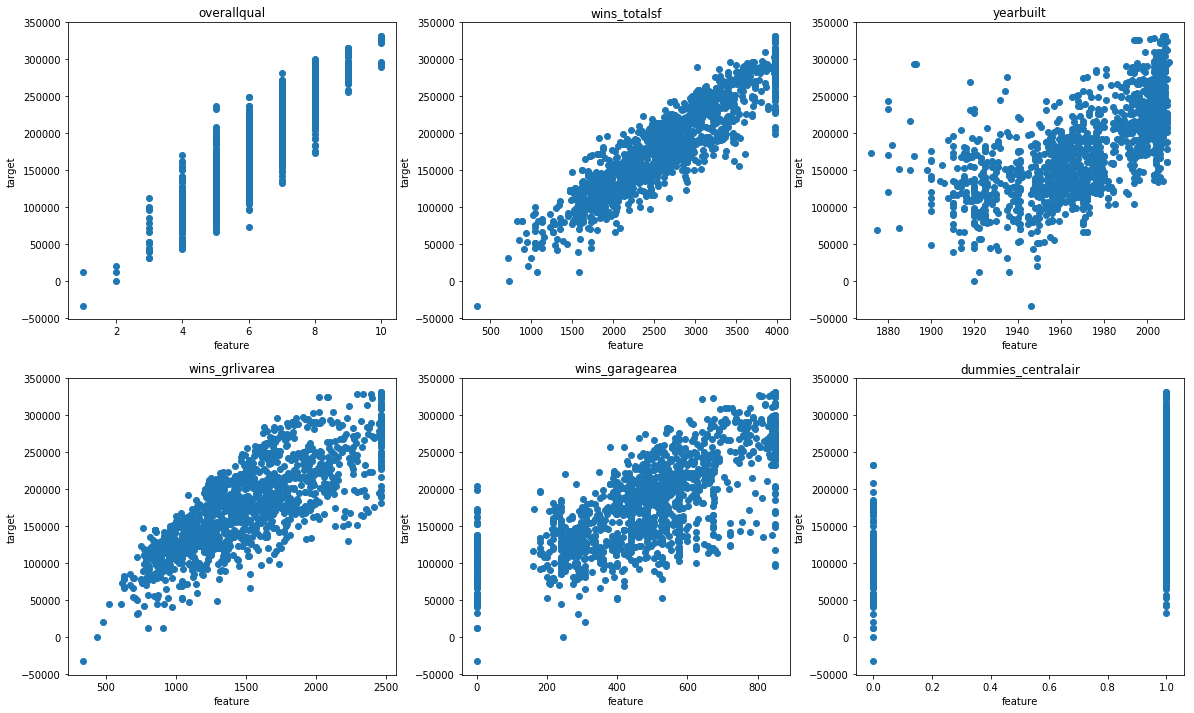

In [34]:
predictions = lrm.predict(X)

plt.figure(figsize=(20,12))


for variable, i in X_variables.items():
                     plt.subplot(2, 3, i)
                     plt.scatter(X[variable], predictions)
                     plt.xlabel("feature")
                     plt.ylabel("target")
                     plt.title(variable)


Assumption met, all are showing a linear relationship

### Assumption two: the error term should be zero on average

In [35]:
errors = Y - predictions

print("Mean of the errors in the houseprices model is: {}".format(np.mean(errors)))

Mean of the errors in the houseprices model is: -1.3953891314872323e-11


Assumption met

### Assumption three: homoscedasticity

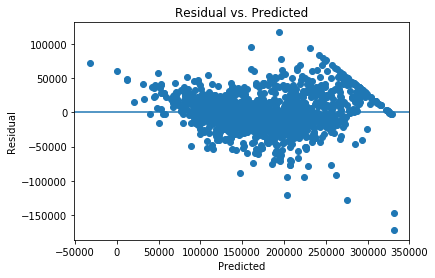

In [36]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [37]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 901.49 and p value is 4.65e-198
Levene test statistic value is 810.523 and p value is 1.54e-157


Assumption not met, data is heteroscedastic

### Assumption four: low multicollinearity

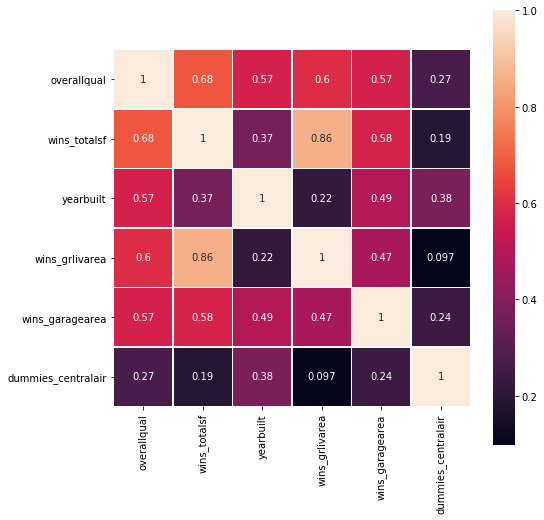

In [38]:
cor_map = X.corr()
fig, ax = plt.subplots(figsize = (8, 8))
sns.heatmap(cor_map, square=True, annot=True, linewidths=.5, ax = ax)

The wins_grlivarea and wins_totalsf variables are correlated, may have to remove one of them. 

### Assumption five: error terms should be uncorrelated with one another

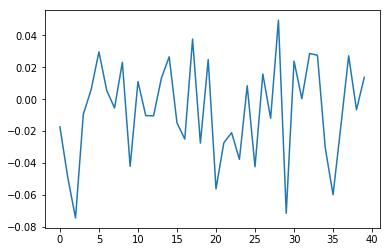

In [39]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

Assumption met, errors do not appear correlated

### Assumption six: features shouldn't be correlated with the errors

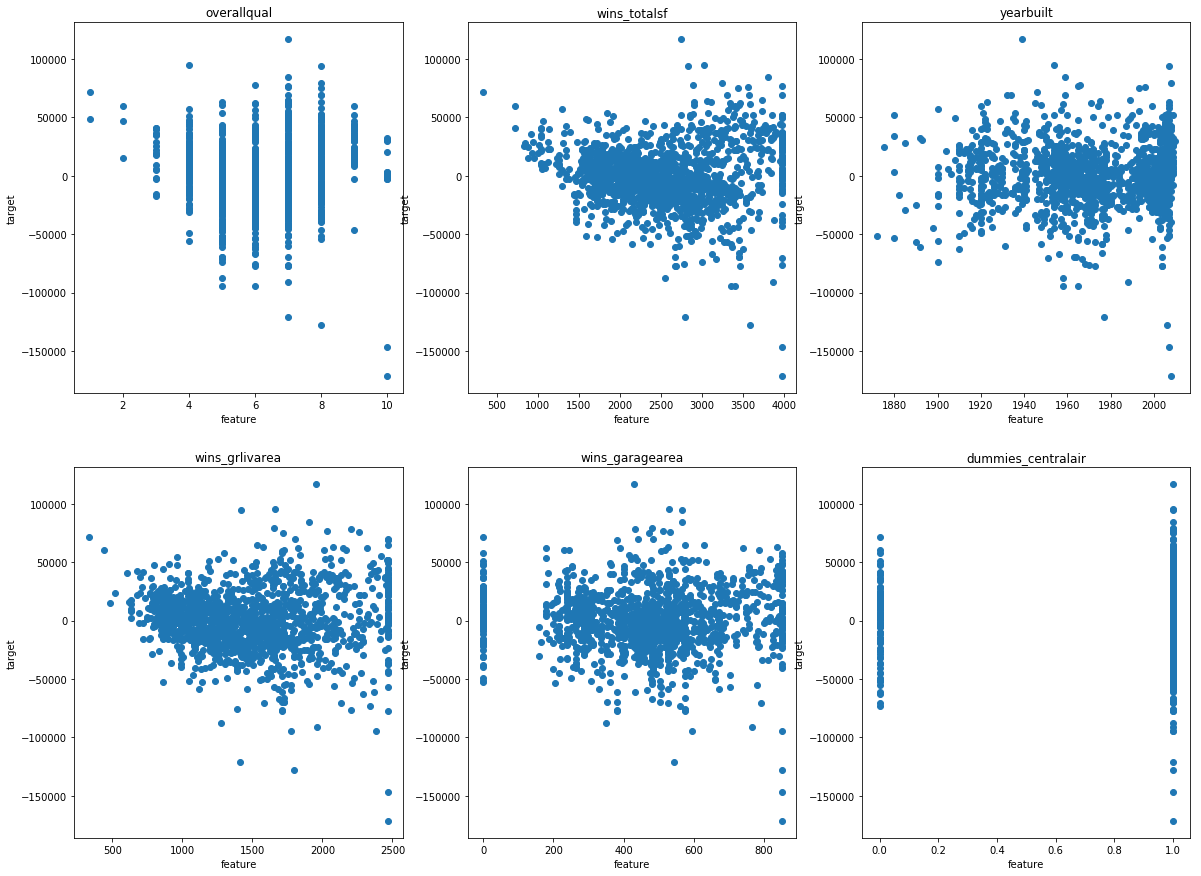

In [40]:
plt.figure(figsize=(20,15))


for variable, i in X_variables.items():
                     plt.subplot(2, 3, i)
                     plt.scatter(X[variable], errors)
                     plt.xlabel("feature")
                     plt.ylabel("target")
                     plt.title(variable)


Assumption met. The features do not appear to be correlated with the errors. 

Text(0.5, 1.0, 'Histogram of the errors')

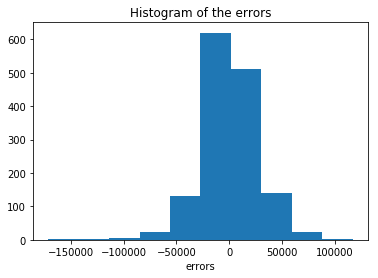

In [41]:
#looking for normality of the error terms

plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

In [42]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 633.9776031762574 and p value is 0.0
Normality test statistics is 140.03662796300762 and p value is 3.9033060583799003e-31


The errors appear normally distributed in the histogram, but are not according to the normality tests. 

## Evaluating Model Performance

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

X = hp[['overallqual', 'fullbath', 'garagecars', 'wins_totalsf', 'wins_grlivarea', 'wins_garagearea']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()

results.summary()

The number of observations in training set is 1168
The number of observations in test set is 292


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         wins_saleprice   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     928.4
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:58:31   Log-Likelihood:                -13586.
No. Observations:                1168   AIC:                         2.719e+04
Df Residuals:                    1161   BIC:                         2.722e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -7.678e+04   3748.783    -20.480      0.000   -8.41e+04   -6.94e+04
overallqual      1.945e+04    877.236     22.174      0.000    1.77e+04    2.12e+04
fullbath          825.6716   1982.077      0.417      0.677   -3063.182    4714.525
garagecars       7372.0874   2607.745      2.827      0.005    2255.668    1.25e+04
wins_totalsf       37.1464      2.482     14.964      0.000      32.276      42.017
wins_grlivarea      6.9608      3.603      1.932      0.054      -0.109      14.030
wins_garagearea    33.4900      9.274      3.611      0.000      15.295      51.685
==============================================================================
Omnibus:                      145.524   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              535.791
Skew:                          -0.564   Prob(JB):                    4.51e-117
Kurtosis:                       6.121   Cond. No.                     1.47e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

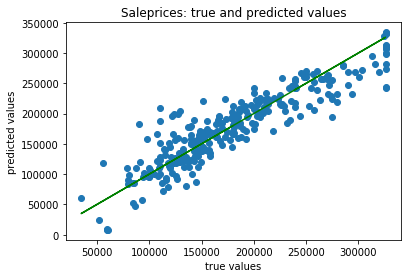

Mean absolute error of the prediction is: 20932.40628153801
Mean squared error of the prediction is: 780740370.9299573
Root mean squared error of the prediction is: 27941.73170957658
Mean absolute percentage error of the prediction is: 14.084978095947681


In [44]:
#making predictions - first model
X_test = sm.add_constant(X_test)

Y_preds = results.predict(X_test)

plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test, color="green")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Saleprices: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds) / Y_test)) * 100))

In [45]:
# second model
X = hp[['overallqual', 'wins_totalsf', 'yearbuilt', 'wins_grlivarea', 'wins_garagearea', 'dummies_centralair']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()

results.summary()

The number of observations in training set is 1168
The number of observations in test set is 292


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         wins_saleprice   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1013.
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:58:31   Log-Likelihood:                -13544.
No. Observations:                1168   AIC:                         2.710e+04
Df Residuals:                    1161   BIC:                         2.714e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.449e+05   6.54e+04     -9.864      0.000   -7.73e+05   -5.17e+05
overallqual         1.623e+04    900.073     18.033      0.000    1.45e+04     1.8e+04
wins_totalsf          33.8169      2.412     14.022      0.000      29.085      38.549
yearbuilt            294.9829     34.613      8.522      0.000     227.072     362.894
wins_grlivarea        17.6026      3.436      5.123      0.000      10.861      24.344
wins_garagearea       42.4184      5.060      8.382      0.000      32.490      52.347
dummies_centralair  9595.4284   3432.905      2.795      0.005    2860.036    1.63e+04
==============================================================================
Omnibus:                      139.834   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              709.193
Skew:                          -0.429   Prob(JB):                    1.00e-154
Kurtosis:                       6.720   Cond. No.                     3.09e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

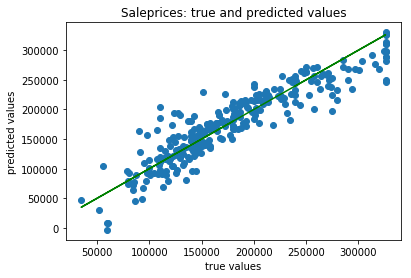

Mean absolute error of the prediction is: 19778.049351284993
Mean squared error of the prediction is: 696947233.8748503
Root mean squared error of the prediction is: 26399.758216219525
Mean absolute percentage error of the prediction is: 13.128641728689864


In [46]:
#making predictions - second model
X_test = sm.add_constant(X_test)

Y_preds = results.predict(X_test)

plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test, color="green")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Saleprices: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds) / Y_test)) * 100))

Again comparing the two models the second model had the best performance in terms of goodness of fit measures and prediction metrics. It had a higher adjusted R-squared and lower AIC & BIC values. Also, the prediction metrics were pretty similar but the second model had a lower measures across the board. There could still be some improvements but overall I think it is performing well. I will now test the model and see if there is any overfitting by looking at the Ridge, Lasso and ElasticNet regressions. 

In [47]:
# OLS model
Y = hp['wins_saleprice']
X = hp[['overallqual', 'wins_totalsf', 'yearbuilt', 'wins_grlivarea', 'wins_garagearea', 'dummies_centralair']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

lrm = linear_model.LinearRegression()

lrm.fit(X_train, Y_train)

Y_preds_train = lrm.predict(X_train)
Y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model in training set is: 0.8396455295328058
-----Test set statistics-----
R-squared of the model in test set is: 0.8375076259255699
Mean absolute error of the prediction is: 19778.04935128522
Mean squared error of the prediction is: 696947233.8749125
Root mean squared error of the prediction is: 26399.758216220704
Mean absolute percentage error of the prediction is: 13.128641728689248


In [48]:
# import linear regression models and set alphas
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [49]:
# Ridge Regression
ridgeregr = RidgeCV(alphas = alphas, cv =5) 
ridgeregr.fit(X_train, Y_train)

Y_preds_train = ridgeregr.predict(X_train)
Y_preds_test = ridgeregr.predict(X_test)

print("Best alpha value is: {}".format(ridgeregr.alpha_))
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model on the training set is: 0.839645185949805
-----Test set statistics-----
R-squared of the model on the test set is: 0.8375651892432581
Mean absolute error of the prediction is: 19774.02945348815
Mean squared error of the prediction is: 696700338.6266649
Root mean squared error of the prediction is: 26395.08171282417
Mean absolute percentage error of the prediction is: 13.12577029006346


In [50]:
# Lasso Regression
lassoregr = LassoCV(alphas = alphas, cv = 5) 
lassoregr.fit(X_train, Y_train)

# We are making predictions here
Y_preds_train = lassoregr.predict(X_train)
Y_preds_test = lassoregr.predict(X_test)

print("Best alpha value is: {}".format(lassoregr.alpha_))
print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model on the training set is: 0.8396455295328058
-----Test set statistics-----
R-squared of the model on the test set is: 0.8375076259255705
Mean absolute error of the prediction is: 19778.04935128518
Mean squared error of the prediction is: 696947233.87491
Root mean squared error of the prediction is: 26399.758216220656
Mean absolute percentage error of the prediction is: 13.128641728689228


In [51]:
# ElasticNet regression
elasticregr = ElasticNetCV(alphas=alphas, cv=5) 
elasticregr.fit(X_train, Y_train)

Y_preds_train = elasticregr.predict(X_train)
Y_preds_test = elasticregr.predict(X_test)

print("Best alpha value is: {}".format(elasticregr.alpha_))
print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

Best alpha value is: 0.01
R-squared of the model on the training set is: 0.8396352145555666
-----Test set statistics-----
R-squared of the model on the test set is: 0.8378181801222981
Mean absolute error of the prediction is: 19755.800648517703
Mean squared error of the prediction is: 695615233.5911403
Root mean squared error of the prediction is: 26374.518641885017
Mean absolute percentage error of the prediction is: 13.112408179666197


After looking at all of the regression models they all are performing similarly on the training and test sets. This is a good sign that there is no overfitting happening. They also all have very similar prediction measures which is another good sign. 

### Improving model performance by adding outside factors

One factor that was not included in this dataset was the average mortgage rate for the year when the house was sold. Mortgage rates can affect saleprices so it may be possible that including them in the model could increase its performance. 

In [52]:
#add mortgage rates for each yearsold
hp['mortgage_rate'] = hp['yrsold']

hp.mortgage_rate.replace([2006, 2007, 2008, 2009, 2010], [6.12, 6.25, 5.68, 5.10, 4.98], inplace = True)

hp.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,wins_saleprice,wins_grlivarea,wins_garagearea,wins_totalbsmtsf,wins_firstflrsf,totalsf,wins_totalsf,dummies_street,dummies_centralair,mortgage_rate
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,208500,1710,548,856,856,2566,2566,1,1,5.68
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,181500,1262,460,1262,1262,2524,2524,1,1,6.25
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,223500,1786,608,920,920,2706,2706,1,1,5.68
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,140000,1717,642,756,961,2473,2473,1,1,6.12
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,250000,2198,836,1145,1145,3343,3343,1,1,5.68


In [59]:
#add to model
# OLS model
Y = hp['wins_saleprice']
X = hp[['overallqual', 'wins_totalsf', 'yearbuilt', 'wins_grlivarea', 'wins_garagearea', 'dummies_centralair', 'mortgage_rate']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

lrm = linear_model.LinearRegression()

lrm.fit(X_train, Y_train)

Y_preds_train = lrm.predict(X_train)
Y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))
X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()

results.summary()

R-squared of the model in training set is: 0.8396455930780526
-----Test set statistics-----
R-squared of the model in test set is: 0.837495063535116
Mean absolute error of the prediction is: 19779.40829667151
Mean squared error of the prediction is: 697001115.3159803
Root mean squared error of the prediction is: 26400.77868768231
Mean absolute percentage error of the prediction is: 13.129548303994188


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         wins_saleprice   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     867.7
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        17:08:56   Log-Likelihood:                -13544.
No. Observations:                1168   AIC:                         2.710e+04
Df Residuals:                    1160   BIC:                         2.714e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.447e+05   6.59e+04     -9.777      0.000   -7.74e+05   -5.15e+05
overallqual         1.623e+04    900.472     18.025      0.000    1.45e+04     1.8e+04
wins_totalsf          33.8176      2.413     14.015      0.000      29.083      38.552
yearbuilt            294.9853     34.628      8.519      0.000     227.045     362.926
wins_grlivarea        17.6033      3.437      5.121      0.000      10.859      24.348
wins_garagearea       42.4178      5.063      8.378      0.000      32.485      52.351
dummies_centralair  9596.1090   3434.531      2.794      0.005    2857.521    1.63e+04
mortgage_rate        -33.1419   1545.781     -0.021      0.983   -3065.981    2999.697
==============================================================================
Omnibus:                      139.804   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              709.011
Skew:                          -0.429   Prob(JB):                    1.10e-154
Kurtosis:                       6.719   Cond. No.                     3.11e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can tell by the model results, adding in mortgage rates did not improve upon our results and in fact the p-value for the mortgage_rate coefficient is close to 1 indicating is is not a useful factor.